In [1]:
# The code was removed by Watson Studio for sharing.

### Import the libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plot
import pandas as pd
import glob
import math
import os, types
from botocore.client import Config
import ibm_boto3
import re
import pickle
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy import stats

### Importing the dataset and merging it

In [3]:
# The code was removed by Watson Studio for sharing.

In [4]:
glued_data = pd.DataFrame()
# directoryPath = "https://github.com/BajajSmriti/WaterSolutionDataset/tree/master/Dataset/"

for f in project.get_files():
    if f['name'][:9] != 'aquastat_':
        
        body = client_7e275d0a644f4293bc5e03b1767859f3.get_object(Bucket='cleanwatersolution-donotdelete-pr-btkhh3gdpwsbhf',Key=f['name'])['Body']
        # add missing __iter__ method, so pandas accepts body as file-like object
        if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
        
        i=0
        x = pd.read_csv(body).iloc[:,1:]
        for col in x.columns:
            if "Unnamed" in col:
                if i==0:
                    i+=1
                    x.rename(columns = {col: "Variables"}, inplace = True, errors = 'raise')
                else:
                    x = x.drop(columns=col)
        diff_cols = glued_data.columns.difference(x.columns)
        glued_data = pd.merge(x, glued_data[diff_cols], left_index=True, right_index=True, how='outer')
dataset = glued_data
dataset = dataset.fillna(0)

### Custom one-hot encoding

In [5]:
cnt=0
j=0
df = pd.DataFrame()
temp = pd.DataFrame()

while len(dataset)>cnt:
    dataset1 = dataset[cnt+j:193+cnt+j]
    dataset2 = dataset[193+cnt+j+1:193*2+cnt+j+1]
    dataset1 = dataset1.reset_index(drop=True)
    dataset2 = dataset2.reset_index(drop=True)
    
    for i in dataset2.columns[1:]:
        if i in dataset1.columns[1:]:
            dataset1[i] = dataset1[i].astype(float)
            dataset2[i] = dataset2[i].astype(float)

            if not dataset2[i].empty:
                try:
                    temp[i] = dataset2[i].subtract(dataset1[i])
                    # if the next year's data has exceeded previous year's data, add 1; if it has decreased, subtract 1; else 0
                    temp[i] = temp[i].apply(lambda x: 1 if x>0 else -1 if x<0 else 0)
                    df[i] = df[i].add(temp[i])
                except:
                    df[i]= dataset2[i].subtract(dataset1[i])
                    df[i] = df[i].apply(lambda x: 1 if x>0 else -1)
    cnt+=193  
    j+=1

df.insert(0, 'Variables', dataset['Variables'])
# df.to_csv('Clean_Variance.csv')

In [6]:
encoded_clean_df = df.set_index('Variables')
encoded_clean_df_T_pro = encoded_clean_df.T

encoded_clean_df_T_pro

Variables,Total area of the country (excl. coastal water) (1000 ha),Arable land area (1000 ha),Permanent crops area (1000 ha),Cultivated area (arable land + permanent crops) (1000 ha),% of total country area cultivated (%),% of cultivated land irrigated [harvested crop] (%),Total population (1000 inhab),Rural population (1000 inhab),Urban population (1000 inhab),Population density (inhab/km2),...,% of area equipped for irrigation drained (%),% of total cultivated area drained (%),Area salinized by irrigation (1000 ha),% of area equipped for irrigation salinized (%),Area waterlogged by irrigation (1000 hectares),Flood occurrence (WRI) (-),Total population with access to safe drinking-water (JMP) (%),Rural population with access to safe drinking-water (JMP) (%),Urban population with access to safe drinking-water (JMP) (%),Population affected by water related disease (1000 inhabitants)
Saint Kitts and Nevis,-3,-3,-7,-6,-4,-1,-2,0,4,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Saint Lucia,-2,-3,0,0,0,-1,10,10,4,10,...,-1,-1,-1,-1,-1,-1,4,4,4,-1
Saint Vincent and the Grenadines,-2,-3,-1,-3,-3,-1,6,-4,10,6,...,-1,-1,-1,-1,-1,-1,2,2,2,-1
Samoa,-2,-2,-4,-3,-3,-1,10,10,4,10,...,-1,-1,-1,-1,-1,-1,4,4,4,-1
San Marino,-2,-2,-1,-2,-2,-1,10,-10,10,10,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela (Bolivarian Republic of),-2,-3,-2,-1,-1,1,10,-4,10,10,...,-1,0,-1,-1,-1,-1,4,4,4,-1
Viet Nam,-1,2,10,8,6,0,10,10,10,10,...,1,-1,-1,-2,-1,-1,4,4,4,-1
Yemen,-2,2,6,2,2,1,10,10,10,10,...,-1,-1,-1,-1,-1,-1,-5,-5,-5,-1
Zambia,-2,3,9,3,3,-1,10,10,10,10,...,-1,-1,-1,-1,-1,-1,4,4,-6,-1


### Extracting the dimensions and applying PCA

In [7]:
dimensions = {}
count = 0
for i in encoded_clean_df_T_pro.T.index:
    dimensions[count] = i
    count += 1

In [8]:
dimensions

{0: 'Total area of the country (excl. coastal water) (1000 ha)',
 1: 'Arable land area (1000 ha)',
 2: 'Permanent crops area (1000 ha)',
 3: 'Cultivated area (arable land + permanent crops) (1000 ha)',
 4: '% of total country area cultivated (%)',
 5: '% of cultivated land irrigated [harvested crop] (%)',
 6: 'Total population (1000 inhab)',
 7: 'Rural population (1000 inhab)',
 8: 'Urban population (1000 inhab)',
 9: 'Population density (inhab/km2)',
 10: 'Gross Domestic Product (GDP) (current US$)',
 11: 'GDP per capita (current US$/inhab)',
 12: 'Agriculture, value added (% GDP) (%)',
 13: 'Agriculture, value added to GDP (current US$)',
 14: 'Industry, value added to GDP (current US$)',
 15: 'Services, value added to GDP (current US$)',
 16: 'Human Development Index (HDI) [highest = 1] (-)',
 17: 'Gender Inequality Index (GII) [equality = 0; inequality = 1) (-)',
 18: 'Prevalence of undernourishment (3-year average) (%)',
 19: 'Number of people undernourished (3-year average) (1000

In [9]:
pca_variables_dim = PCA(n_components=193)

pca_variables_dim.fit(encoded_clean_df_T_pro)

pca_variables_dim_comps = pca_variables_dim.fit_transform(encoded_clean_df_T_pro)

encoded_clean_df_T_pro.shape

(200, 193)

### Visualizing the insights

In [10]:
percent_variance = []
for i in pca_variables_dim.explained_variance_ratio_:
    percent_variance.append(i*100)

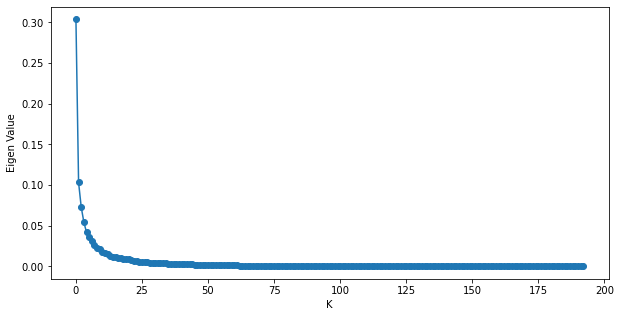

In [11]:
m = pca_variables_dim.explained_variance_ratio_

# plotting code
fig = plt.figure(figsize=(10,5))
ax = plt.gca()
ax.set_xlabel("K")
ax.set_ylabel("Eigen Value")
ax.plot(m, '-o')

Number of components needed to explain around 50% of the total variance :  4
Number of components needed to explain around 75% of the total variance :  13
Number of components needed to explain around 90% of the total variance :  31


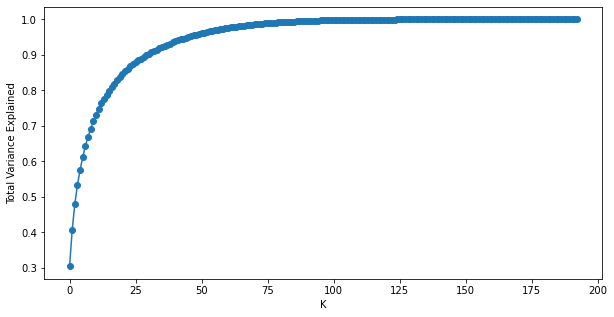

In [12]:
count = 1
count90 = 1
count75 = 1
K = 0
K_var = {}
total_var = 0
for i in m:
    total_var = total_var + i
    K_var[K] = total_var
    if total_var <= 0.50:
        count += 1
    if total_var <= 0.75:
        count75 += 1
    if total_var <= 0.90:
        count90 += 1
    K += 1

print("Number of components needed to explain around 50% of the total variance : ",(count))
print("Number of components needed to explain around 75% of the total variance : ",(count75))
print("Number of components needed to explain around 90% of the total variance : ",(count90))

K_var_list = []
for i in K_var.values():
    K_var_list.append(i)

# plotting code
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
ax.set_xlabel("K")
ax.set_ylabel("Total Variance Explained")
ax.plot(K_var_list, '-o')

In [13]:
pca_variables_dim.components_.shape

(193, 193)

In [14]:
print('The estimated number of components :' , pca_variables_dim.n_components_)
print('Number of features in the training data :' , pca_variables_dim.n_features_)
print('Number of samples in the training data :' , pca_variables_dim.n_samples_)

The estimated number of components : 193
Number of features in the training data : 193
Number of samples in the training data : 200


In [15]:
eigen_vectors = pca_variables_dim.components_.T

eigen_vectors.shape

(193, 193)

In [16]:
sum_eigen_vectors = np.absolute(eigen_vectors)

In [17]:
sum_eigen_vectors = (sum_eigen_vectors.sum(axis=0))

In [18]:
# creating U of dxk dimensions with components having absolute larger than 0.20 of the norm
count = 0
U_dxk = []
percent_list = []
arr = []
for i in range(193):
    col = []
    col_perc = []
    for j in range(len(eigen_vectors[0])):
        if abs(eigen_vectors[j][i]) > (0.2*sum(eigen_vectors[i]**2)):
            col.append(1)
            col_perc.append((abs(eigen_vectors[j,i])/sum_eigen_vectors[i])*100)
        else:
            col.append(0)
    percent_list.append(col_perc)
    U_dxk.append(col)

#fetching respective words for those components
pc_dim = dict()
c = 1
for x in U_dxk:
    for i in range(193):
        if x[i] == 1:
            if c not in pc_dim:
                pc_dim[c] = [dimensions[i]]
            else:
                pc_dim[c].append(dimensions[i])        
    c += 1

print('For all the principal components, below Variables (features) are important:- ')
pc_dim

For all the principal components, below Variables (features) are important:- 


{1: ['Permanent crops area (1000 ha)',
  'Cultivated area (arable land + permanent crops) (1000 ha)',
  '% of total country area cultivated (%)',
  'Total population (1000 inhab)',
  'Rural population (1000 inhab)',
  'Urban population (1000 inhab)',
  'Population density (inhab/km2)',
  'Total internal renewable water resources per capita (m3/inhab/yr)',
  'Total renewable water resources per capita (m3/inhab/yr)'],
 2: ['Arable land area (1000 ha)',
  'Cultivated area (arable land + permanent crops) (1000 ha)',
  '% of total country area cultivated (%)',
  'Rural population (1000 inhab)',
  'Total dam capacity (km<sup>3</sup>)'],
 3: ['Total population (1000 inhab)',
  'Rural population (1000 inhab)',
  'Dam capacity per capita (m3/inhab)',
  'Total water withdrawal (10^9 m3/yr)',
  'Total water withdrawal per capita (m<sup>3</sup>/year per inhabitant)',
  'Total freshwater withdrawal (10^9 m3/yr)',
  'MDG 7.5. Freshwater withdrawal as % of total renewable water resources (%)',
  'SD

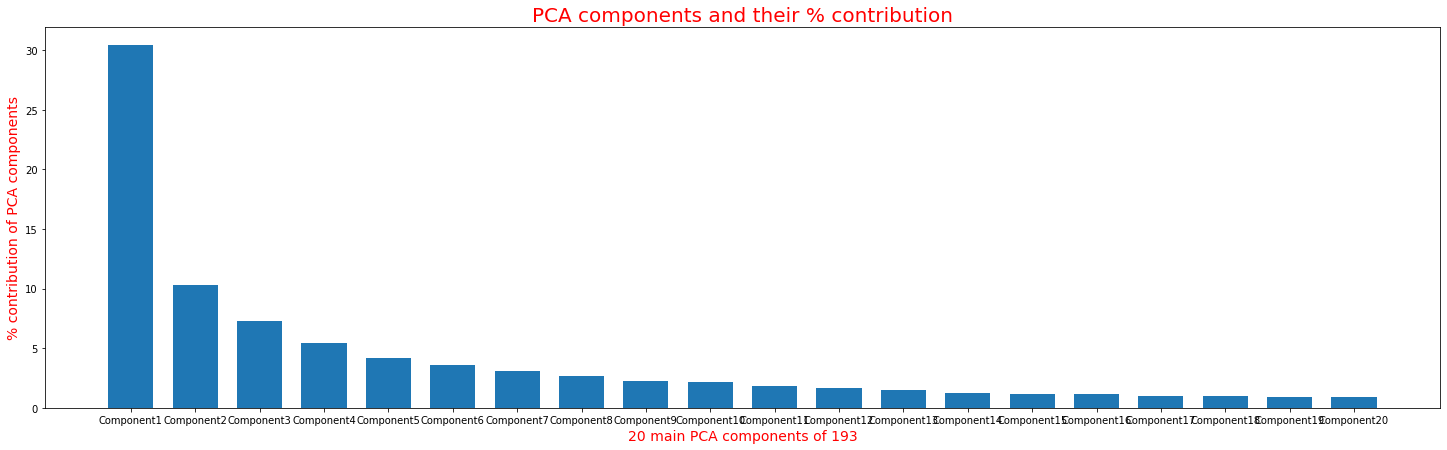

In [19]:
pca_list = []
for pca_comp in pc_dim:
    pca_list.append("Component"+str(pca_comp))

plt.subplots(figsize=(25,7))
plt.bar(pca_list[:20], percent_variance[:20], width = 0.7, align='center')
plt.xlabel('20 main PCA components of 193', fontsize=14,
          color="red") 
plt.ylabel('% contribution of PCA components', fontsize=14,
          color="red") 
plt.title("PCA components and their % contribution", fontsize=20,
          color="red")
plt.show()

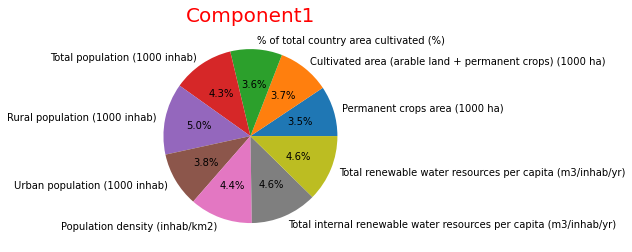

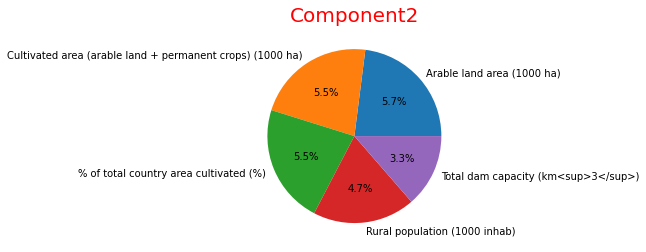

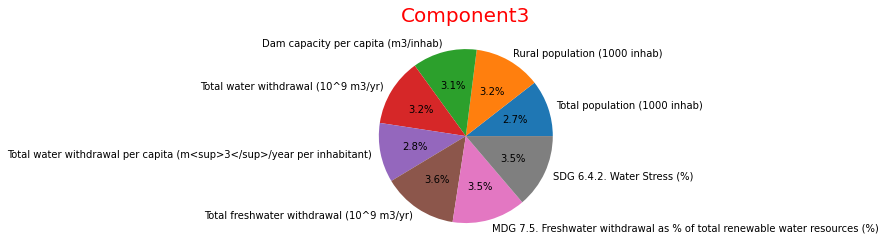

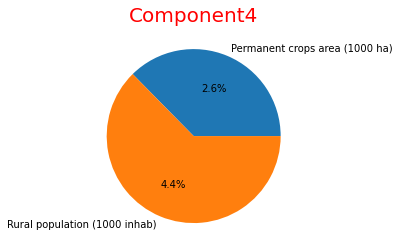

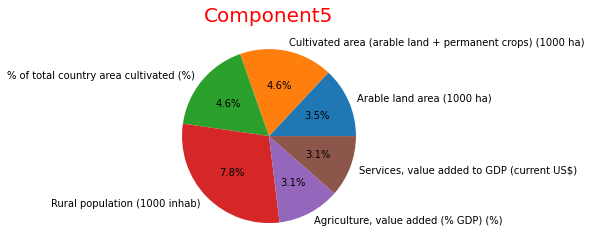

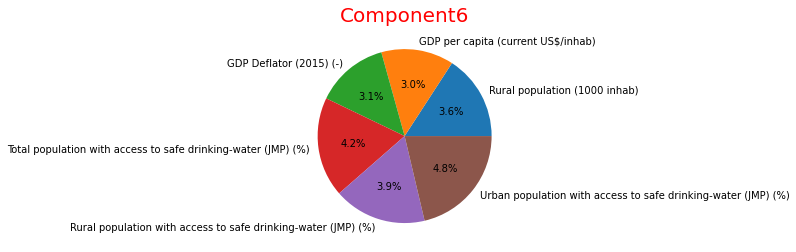

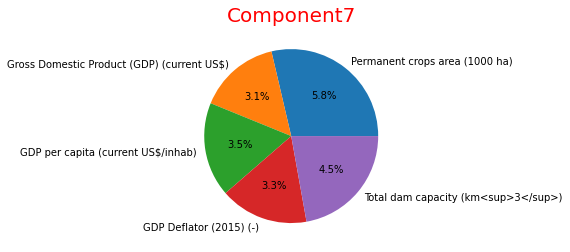

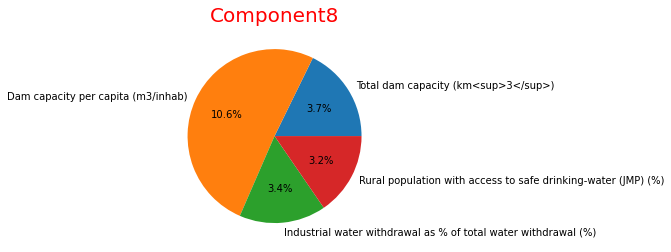

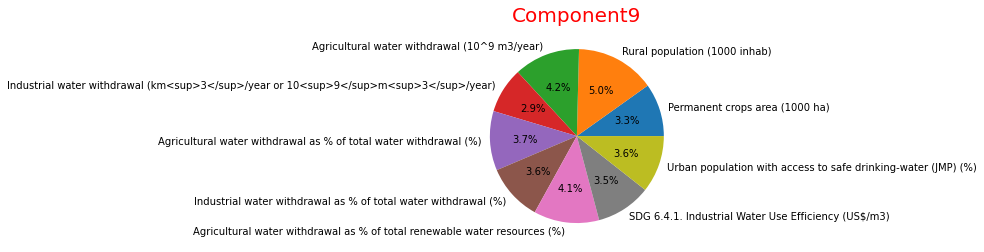

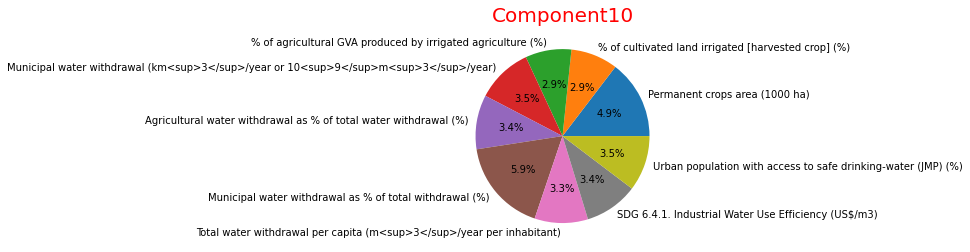

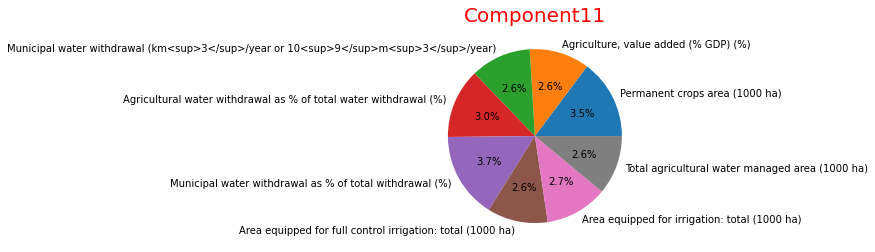

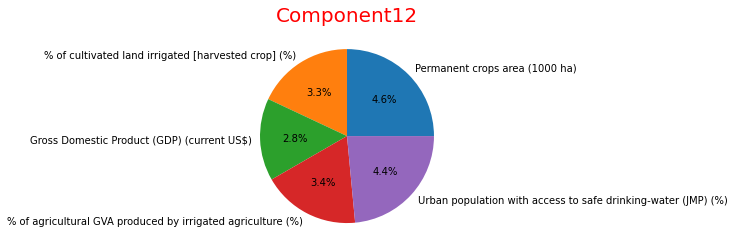

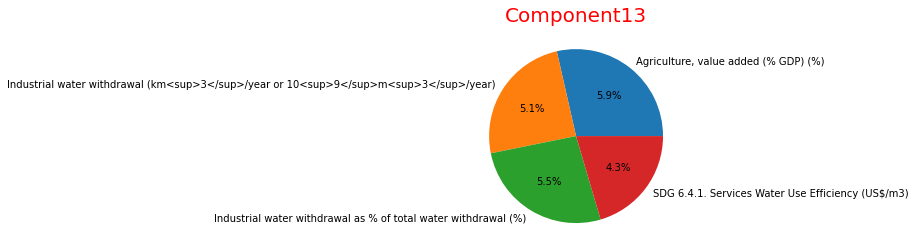

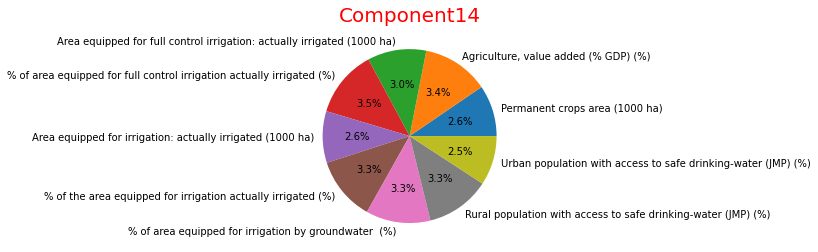

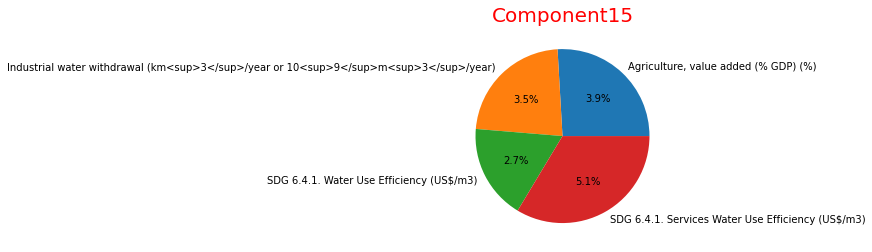

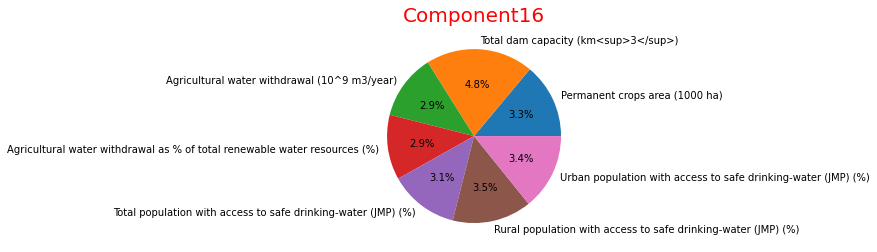

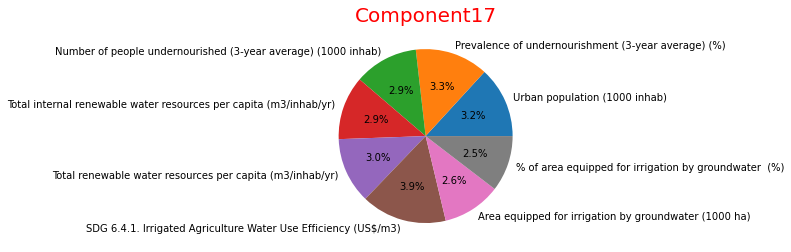

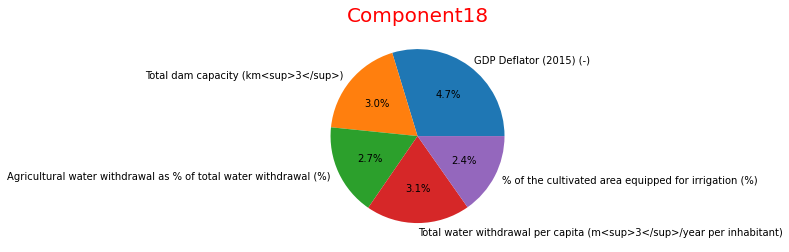

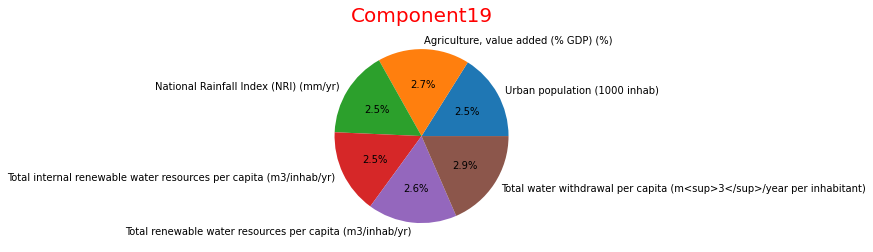

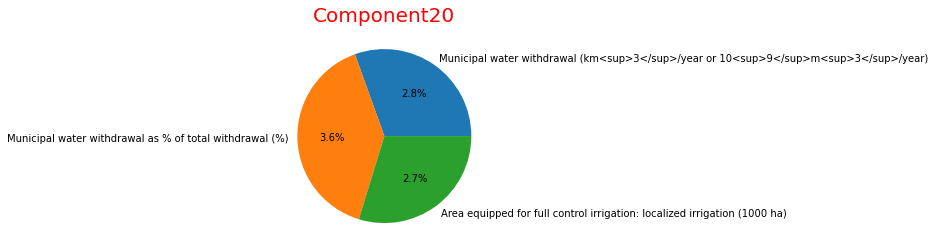

In [20]:
def func(pct,p):
    return "{:.1f}%".format(pct*sum(p)/100)


for comp,dim,p in zip(pca_list[:20],pc_dim,percent_list[:20]):
    plt.title(comp, fontsize=20,
          color="red")
    plt.pie(p, labels = pc_dim[dim], autopct = lambda pct: func(pct,p))
    plt.show()
    